In [1]:
!unzip -qq /kaggle/input/panda256/train

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import gc, re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt
import albumentations
import cv2

import torch
import torch.utils.data as data_utils
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler
from torch import nn

from torchvision import transforms,models
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch import Tensor

from collections import OrderedDict

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/panda256/train
/kaggle/input/panda256/train.csv


In [3]:
BASE_DIR = '/kaggle/input/panda256'
DATA_DIR = '/kaggle/working/kaggle/working/train_images'

In [4]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917_0,karolinska,0,0+0
1,0005f7aaab2800f6170c399693a96917_1,karolinska,0,0+0
2,0005f7aaab2800f6170c399693a96917_2,karolinska,0,0+0
3,0005f7aaab2800f6170c399693a96917_3,karolinska,0,0+0
4,0005f7aaab2800f6170c399693a96917_4,karolinska,0,0+0


In [5]:
# train_df = train_df.loc[0: 2000]

In [6]:
val_df = train_df.sample(frac=0.01).reset_index()
val_df

,index,image_id,data_provider,isup_grade,gleason_score
0,77369,d707d86264e14f3d3f5bac156693e8f9_10,radboud,5,4+5
1,34570,62dafe3f86f1f7048c16ac69f74cb293_3,radboud,3,4+3
2,58262,a28e296c8480489a03db3731aa364183_4,karolinska,1,3+3
3,58121,a23accdd92c621553d8e58b8b40eed83_8,radboud,4,4+4
4,18546,35c8527cc2fb55f7d9d96d63bc9bd165_11,karolinska,0,0+0
...,...,...,...,...,...
919,89423,f83b92c580fa7d6faf97f81474d9b2e8_5,karolinska,1,3+3
920,45124,8013d514fff8374e2f0435f808a57d8e_2,radboud,0,negative
921,53450,96bb7ad81bef9aa7ce0280d7b49b6476_0,karolinska,4,4+4
922,56543,9e72c86ff601172cb3900d6d57c0ad6c_10,karolinska,2,3+4


In [7]:
train_df = train_df.loc[~train_df.index.isin(train_df.sample(frac=0.1).index)].reset_index()
train_df

,index,image_id,data_provider,isup_grade,gleason_score
0,0,0005f7aaab2800f6170c399693a96917_0,karolinska,0,0+0
1,1,0005f7aaab2800f6170c399693a96917_1,karolinska,0,0+0
2,2,0005f7aaab2800f6170c399693a96917_2,karolinska,0,0+0
3,3,0005f7aaab2800f6170c399693a96917_3,karolinska,0,0+0
4,4,0005f7aaab2800f6170c399693a96917_4,karolinska,0,0+0
...,...,...,...,...,...
83179,92422,ffe9bcababc858e04840669e788065a1_4,radboud,4,4+4
83180,92423,ffe9bcababc858e04840669e788065a1_5,radboud,4,4+4
83181,92424,ffe9bcababc858e04840669e788065a1_6,radboud,4,4+4
83182,92425,ffe9bcababc858e04840669e788065a1_7,radboud,4,4+4


In [8]:
# Constants
BATCH_SIZE = 16
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class PandaDataset(Dataset):
    """Custom dataset for PANDA"""
    
    def __init__(self, df, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.df = df
        self.aug = albumentations.Compose([
            albumentations.ShiftScaleRotate(shift_limit=0.0625,
                                           scale_limit=0.15, 
                                           rotate_limit=10,
                                           p=0.9),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Normalize(mean, std, always_apply=True)
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_id = self.df.loc[index]['image_id']
        image = cv2.imread(os.path.join(DATA_DIR, f'{image_id}.jpg'))
        image = self.aug(image=image)['image']
        
        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        
        # For now, just return image and ISUP grades
        return image, self.df.loc[index]['isup_grade']

In [10]:
train_dataset = PandaDataset(train_df)
train_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
val_dataset = PandaDataset(val_df)
val_loader = data_utils.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

In [13]:
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(*inputs)

        return cp.checkpoint(closure, input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

In [14]:
class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

In [15]:
class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    __constants__ = ['features']

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),  # 3 is number of channels in input image
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [16]:
def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


In [17]:
def _densenet(growth_rate, block_config, num_init_features, **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    _load_state_dict(model, 'https://download.pytorch.org/models/densenet121-a639ec97.pth', True)
    return model

In [18]:
def densenet121(**kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    """
    return _densenet(32, (6, 12, 24, 16), 64, **kwargs)

In [19]:
class DenseNet121Wrapper(nn.Module):
    def __init__(self):
        super(DenseNet121Wrapper, self).__init__()
        
        # Load imagenet pre-trained model 
        self.dense_net = densenet121()
        
        # Appdend output layers based on our date
        self.out = nn.Linear(in_features=1000, out_features=6)
        
    def forward(self, X):
        output = self.dense_net(X)
        output = self.out(output)
        
        return output

In [20]:
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [21]:
model = DenseNet121Wrapper().to(DEVICE)
clear_cache()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [22]:
LEARNING_RATE = 0.025
EPOCHS = 25

In [23]:
model = nn.DataParallel(model)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.00001, eps=1e-08)
criterion = nn.CrossEntropyLoss()

In [24]:
def get_accuracy(preds, targets):
    assert len(preds) == len(targets)
    
    total = len(preds)
    _, preds = torch.max(preds.data, axis=1)

    correct = (preds == targets).sum().item()
    return correct / total

In [25]:
total_steps = len(train_loader)
val_acc_list = []

for epoch in range(EPOCHS):
    for i, (x_train, y_train) in tqdm(enumerate(train_loader), total=total_steps):
        
        x_train = x_train.to(DEVICE, dtype=torch.float32)/255
        y_train = y_train.to(DEVICE, dtype=torch.long)
        
        
        # Forward pass
        preds = model(x_train)
        loss = criterion(preds, y_train)
        
        # Backpropagate
        optimizer.zero_grad()  # Reason: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        loss.backward()
        optimizer.step()
    
    lr_scheduler.step(loss.item())

    # Calculate validation accuracy after each epoch
    # Predict on validation set
    
    correct = 0
    val_size = len(val_loader)
    for x_val, y_val in val_loader:
        
        x_val = x_val.to(DEVICE, dtype=torch.float32)/255
        y_val = y_val.to(DEVICE, dtype=torch.long)
        
        val_preds = model(x_val)
        _, preds = torch.max(val_preds.data, axis=1)

        correct += (preds == y_val).sum().item()

    val_acc = correct / len(val_df)
    val_acc_list.append(val_acc)

    print('Epoch [{}/{}], Loss: {:.4f}, Validation accuracy: {:.2f}%'
          .format(epoch + 1, EPOCHS, loss.item(), val_acc * 100))


Epoch [2/25], Loss: 1.5717, Validation accuracy: 41.02%



Epoch [6/25], Loss: 1.4599, Validation accuracy: 43.51%


Epoch [15/25], Loss: 1.0534, Validation accuracy: 49.13%


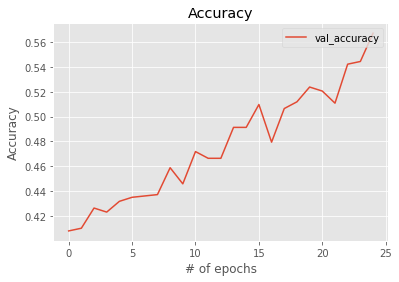

In [26]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, EPOCHS), val_acc_list, label='val_accuracy')


plt.title('Accuracy')
plt.xlabel('# of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [27]:
# Remove all the images from working directory to prevent them from kernel's output
!rm -rf *

In [28]:
torch.save(model.state_dict(), 'densenet121_256_25.pth')